# Week 12: Part 2 - PCA 

**DATA110**
*Brian Roepke*

This is an extension of the project using the wine dataset.

1. use PCA for dimensionality reduction. Try different component values to find the minimum principal components that explains most of the variability. Plot a scatterplot for each iteration.

2. Create any 3 multi-class models. See: https://scikit-learn.org/stable/modules/multiclass.html

3. Create a pipeline that includes the classifier and StandardScaler. For the PCA models, also include PCA.

4. Compare the results of each classifier with and without PCA. Compare models using Kfold cross validation with 10 folds. This means you will have 6 models (3 without PCA and 3 without PCA)

References:

https://scikit-learn.org/stable/modules/cross_validation.html

In [1]:
import numpy as np
import pandas as pd
import itertools
from timeit import timeit
import warnings
warnings.filterwarnings('ignore')

# Validation Metrics
from sklearn import metrics

# Pipeline and preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression #(setting multi_class=”multinomial”)
from sklearn.linear_model import Perceptron

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("wine.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Class                 178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Ash Alcalinity        178 non-null    float64
 5   Magnesium             178 non-null    int64  
 6   Total phenols         178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid phenols  178 non-null    float64
 9   Proanthocyanins       178 non-null    float64
 10  Color intensity       178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD280/OD315           178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [4]:
df['Class'].value_counts()

2    71
1    59
3    48
Name: Class, dtype: int64

In [5]:
df.shape

(178, 14)

# Data Setup

 - create a `labels` variable from the `Class`
 - drop the `Class` from the dataset and create a new variable called `data` with that.

In [6]:
y = df['Class'].copy()
X = df.drop(columns=['Class']).copy().values

In [7]:
print(X.shape)
print(y.shape)

(178, 13)
(178,)


# Find Explained Variance

For this dataset there are a potential of 13 total components. Each component explains a certain amount of variance, and adding additional components will increase the amount explained.  The plot below shows this first component explaining `0.362` of the overall variance increasing all the way to `1` for all `13` components.  At `9` components, `94.2%` of the variance is explained.

**References:**
1. https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff

In [8]:
def get_variance(X, n):
    scaler = StandardScaler()
    pca = PCA(n_components=n)

    pca.fit(scaler.fit_transform(X))
    
    return pca.explained_variance_ratio_.cumsum()[-1:]

In [9]:
for i in range(1,14):
    print('Components:\t', i, '=\t',get_variance(X, i), '\tCumulative Variance')

Components:	 1 =	 [0.36198848] 	Cumulative Variance
Components:	 2 =	 [0.55406338] 	Cumulative Variance
Components:	 3 =	 [0.66529969] 	Cumulative Variance
Components:	 4 =	 [0.73598999] 	Cumulative Variance
Components:	 5 =	 [0.80162293] 	Cumulative Variance
Components:	 6 =	 [0.85098116] 	Cumulative Variance
Components:	 7 =	 [0.89336795] 	Cumulative Variance
Components:	 8 =	 [0.92017544] 	Cumulative Variance
Components:	 9 =	 [0.94239698] 	Cumulative Variance
Components:	 10 =	 [0.96169717] 	Cumulative Variance
Components:	 11 =	 [0.97906553] 	Cumulative Variance
Components:	 12 =	 [0.99204785] 	Cumulative Variance
Components:	 13 =	 [1.] 	Cumulative Variance


## Plot the Threshold for Explained Variance
Another way to look at the exact same information above is to plot the cumulative explained variance showing how the curve flattens slightly around `6` or `7` components.  A line has been drawn for 95% total explained variance as stated above at approximatley `9` components.

**References:**
1. https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

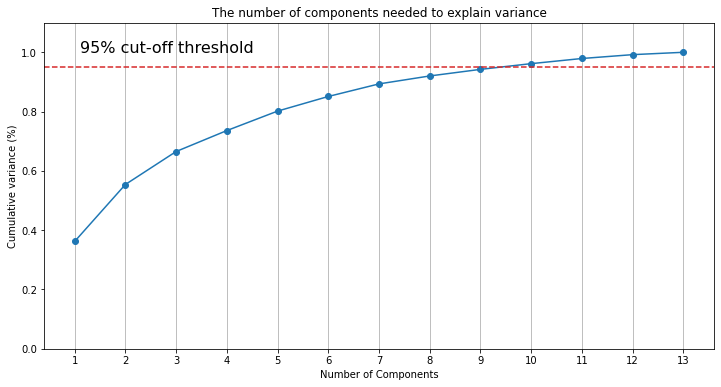

In [10]:
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(X)

pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 14, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='tab:blue')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 14, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='tab:red', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.show()

## Plotting Each Component vs. Original Data

Next, we can plot each of the transformed data for each of the PCA component dimensions and visualize what the data looks like.  

With only a singular component, the dataset is transformed into a line represented but the first eigenvectors.  As the number of components increases, it becomes clear that the data starts to transform and look more like the original dataset.  Starting at `9` components, the two are generally indisinguishable from each other, this is the 95% threshold from above.

**References:**
1. https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [11]:
def transform_pca(X, n):
    '''Function to perform a PCA fit on X and return a transformed and then inverse transformed
    set of data for a given (n) number of PCA components'''
    
    pca = PCA(n_components=n)
    pca.fit(X)
    X_new = pca.inverse_transform(pca.transform(X))
    
    return X_new

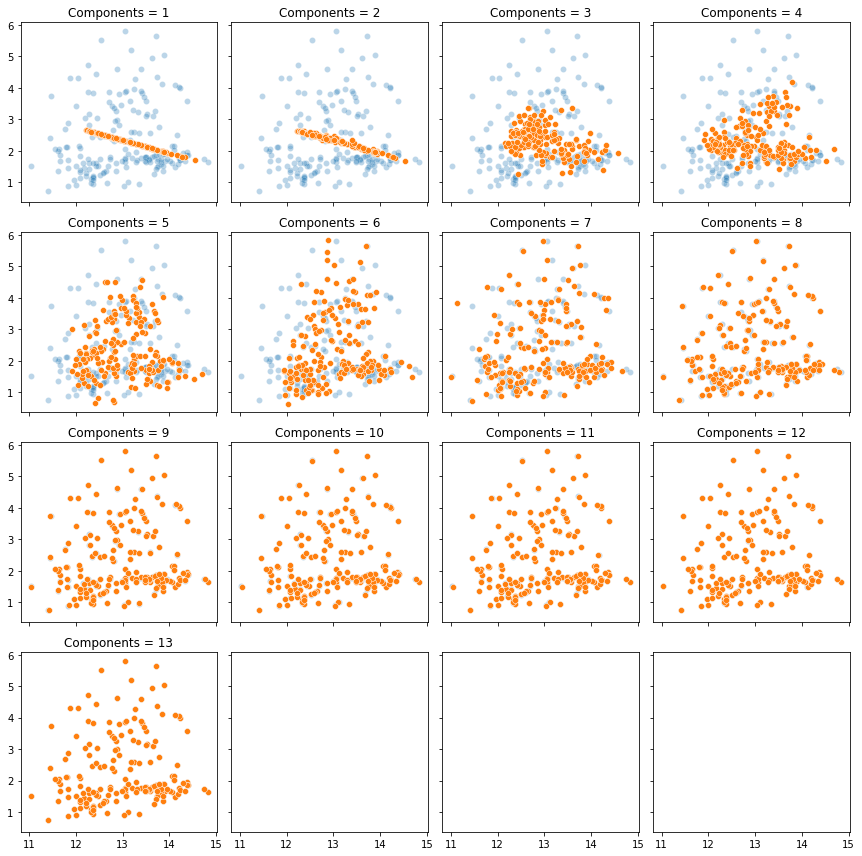

In [12]:
rows = 4
cols = 4
comps = 1

fig, axes = plt.subplots(rows, cols, figsize=(12,12), sharex=True, sharey=True)


for row in range(rows):
    for col in range(cols):
        try:
            # One
            X_new = transform_pca(X, comps)
            ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], ax=axes[row, col], palette='tab20', alpha=.3)
            ax = sns.scatterplot(x=X_new[:, 0], y=X_new[:, 1], ax=axes[row, col], palette='tab20')
            ax.set_title(f'Components = {comps}');

            comps += 1
        except:
            pass
plt.tight_layout()

## Comparing PCA and Non-PCA Classification Models

The following section demonstrates the effects of PCA on a dataset with various classifiers.

1. **PCA vs. Non PCA**: Demonstrate three different classifiers `KNeighborsClassifier`, `RandomForestClassifier`, and `LogisticRegression` against the dataset. First without PCA and second with PCA (`n_components=2`).  Compare the Results.
1. **Model Optimization and Validation**: Using the `GridSearch` function, find the optimal parameters for our `n_components` and evaluate the final results.

### PCA vs. Non PCA

In [13]:
y = df['Class'].copy()
X = df.drop(columns=['Class']).copy().values

In [14]:
def create_pipe(clf, do_pca=False, n=2):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    scaler = StandardScaler()
    pca = PCA(n_components=n)

    # Build estimator from PCA and Univariate selection:
    if do_pca == True:
        combined_features = FeatureUnion([("scaler", scaler), ("pca", pca)])
    else:
        combined_features = FeatureUnion([("scaler", scaler)])
    
    pipeline = Pipeline([("features", combined_features), ("clf", clf)])

     
    return pipeline

In [16]:
models = {'KNeighbors' : KNeighborsClassifier(),
          'RandomForest' : RandomForestClassifier(random_state=42),
          'LogisticReg' : LogisticRegression(multi_class='multinomial', random_state=42),
          'Perceptron' : Perceptron(random_state=42)}


def run_models(with_pca):
    for name, model, in models.items():
        clf = model
        pipeline = create_pipe(clf, do_pca = with_pca, n=2)
        cv = KFold(n_splits=10, random_state=1)
        scores = cross_val_score(pipeline, X, y, scoring='accuracy', 
                                 cv=cv, n_jobs=-1, error_score='raise')
        print(name, ': Mean Accuracy: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), 
                                                                              np.std(scores)))

print(80 * '-')
print('Without PCA')
print(80 * '-')
run_models(False)
print(80 * '-')
print('With PCA')
print(80 * '-')
run_models(True)

--------------------------------------------------------------------------------
Without PCA
--------------------------------------------------------------------------------
KNeighbors : Mean Accuracy: 0.939 and Standard Deviation: (0.068)
RandomForest : Mean Accuracy: 0.967 and Standard Deviation: (0.057)
LogisticReg : Mean Accuracy: 0.967 and Standard Deviation: (0.037)
Perceptron : Mean Accuracy: 0.978 and Standard Deviation: (0.037)
--------------------------------------------------------------------------------
With PCA
--------------------------------------------------------------------------------
KNeighbors : Mean Accuracy: 0.619 and Standard Deviation: (0.242)
RandomForest : Mean Accuracy: 0.950 and Standard Deviation: (0.072)
LogisticReg : Mean Accuracy: 0.961 and Standard Deviation: (0.066)
Perceptron : Mean Accuracy: 0.457 and Standard Deviation: (0.387)


**Results**:  
1. `KNeighbors` and `Perceptron` both performed worse with the dimensions reduced, about `30%` reduction in accuracy
1. `RandomForest` and `LogisticRegression` only performed `~.5%` worse when the data was reduced to only `2` dimensions.

## Model Optimization and Validation

For this portion, we'll use the `train_test_split` function to split the dataset into `70/30%` partitions and then use the `GridSearch` feature to find optimal parameters.  The most critical parameter here that we want to validate is the performance of various **PCA component number** settings.   We will test the entire range from `1-13` and find the best setting.  As we saw from the scatterplots above, when we approach higher numbers like `9`, the dataset after transformation looks a lot like the original with `95%` of the variation explained by the transformed dataset.  

In [17]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

In [18]:
print(y_train.shape)
print(X_train.shape)

(124,)
(124, 13)


In [25]:
def get_params(parameters, X, y, pipeline):
    ''' implements a the GridSearch Cross validation for a given model and set of parameters'''
    
    cv = KFold(n_splits=3, random_state=1)
    grid = GridSearchCV(pipeline, parameters, scoring='accuracy', n_jobs=-1, cv=cv, error_score='raise')
    grid.fit(X, y)

    return grid

In [26]:
clf = LogisticRegression(random_state=41)
pipeline = create_pipe(clf, do_pca=True)

param_grid = dict(features__pca__n_components = list(range(1,14)),
                 clf__C = [0.1, 1.0, 10,],
                 clf__solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

grid = get_params(param_grid, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.968
Test set score: 0.926
Best parameters: {'clf__C': 10, 'clf__solver': 'liblinear', 'features__pca__n_components': 1}


## Model Validation

Perform a final fit and test with the new parameters.  One for our optimized Number of Components (`1`) and one for a set of data that has not had PCA performed on it.

In [116]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [117]:
def fit_and_print(pipeline):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_test, y_pred, labels=[1,2,3])
    plot_confusion_matrix(cm, classes=[1,2,3])

              precision    recall  f1-score   support

           1      0.933     1.000     0.966        14
           2      1.000     0.864     0.927        22
           3      0.900     1.000     0.947        18

    accuracy                          0.944        54
   macro avg      0.944     0.955     0.947        54
weighted avg      0.949     0.944     0.944        54

Confusion matrix, without normalization


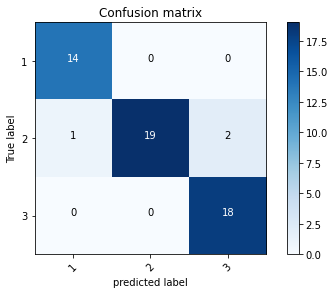

In [144]:
clf = LogisticRegression(C=1, solver='liblinear', random_state=41)
pipeline = create_pipe(clf, do_pca=True, n=1)
fit_and_print(pipeline)

In [145]:
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('scaler', StandardScaler()),
                                                ('pca', PCA(n_components=1))])),
                ('clf',
                 LogisticRegression(C=1, random_state=41, solver='liblinear'))])

              precision    recall  f1-score   support

           1      1.000     1.000     1.000        14
           2      1.000     0.955     0.977        22
           3      0.947     1.000     0.973        18

    accuracy                          0.981        54
   macro avg      0.982     0.985     0.983        54
weighted avg      0.982     0.981     0.982        54

Confusion matrix, without normalization


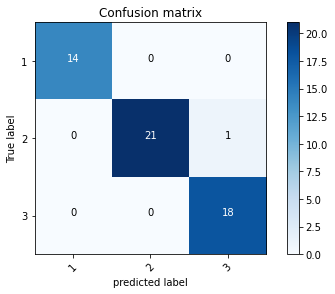

In [146]:
clf = LogisticRegression(C=1, solver='liblinear', random_state=41)
pipeline = create_pipe(clf, do_pca=False)
fit_and_print(pipeline)

In [147]:
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('scaler', StandardScaler())])),
                ('clf',
                 LogisticRegression(C=1, random_state=41, solver='liblinear'))])

**Note**: The pipelines have been printed out under the models to display the configurations used.

# Conclusion

1. These examples clearly demonstrate the power of performing PCA on datasets.  
1. From the visualizations show, there is a stark contrast between the original dataset and the final one used with only `1` principle component.  While the variance explained by that model was only `36%` we were able to get a final performace similar to the original dataset with all dimensions present.
1. The time to compute these models is very small given the size of the data, however this could have massive effects on model performance for large sets.
1. In the end, our `PCA` model misclassified `3` items and the full model misclassified only `1`.